# Hello and congrats on the phd!!
This notebook will help you streamline your graduation photo according to the rest of team VAP-lab. The code should be light weight, with the exception of the inpainting tool, which is voluntary. 


First, you need to install the requirements. Please make sure you have conda installed and run the following commands in *your terminal* and make sure your notebook is running on the environment

In [3]:
## RRun in terminal, not in notebook 
conda env create -f environment.yml
conda activate phd

SyntaxError: invalid syntax (3265784366.py, line 3)

When running cells in the notebook, you should run them through the newly created 'phd' kernel. You may verify that you are running the notebook in the correct environment if the following code outputs an environment at location "envs/phd". 

If the environemnt is not available, try shutting down you editor and opening it again (you just got a PhD, and we still resolve to turning this on and off)

In [2]:
! conda list | grep "packages in environment"

# packages in environment at /home/vap/miniconda3/envs/phd:


To make things smoother, please help define the following variables

In [3]:
your_name = "Someone clever" # As you would want on your poster
phd_title = "Something very smart and very groundbreaking"
date_of_graduation = "DD-MM-YYYY" # format: DD-MM-YYYY
path_to_image = "Pictures/"

The notebook contains methods for 
- Cropping the image
- Removing background (although we recommend using www.remove.bg for complex cases)

- Inpainting for creating missing details or removing various items (voluntary)

And finally creating the actual pdf which will go on the Wall of Fame


### Initialisation
Please run the cells below to get started

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os, re
from PIL import Image, ImageOps
import tkinter as tk # for UIs *
import cv2 # for face detection

def resize_wrt_ratio(img, desired_height): 
    ratio = img.width/img.height

    img = img.resize((int(desired_height*ratio), desired_height))
    return img

In [5]:
name = your_name.replace(" ", "").lower()
path = path_to_image
filename = ""


if type(path) == type(None) or path == "":
    print(f"Searching current folder for photo of {your_name}")
else: 
    path = os.getcwd() + "/" + path
    
    print(f"Searching folder at {path} for photo of {your_name}")

if filename == "": 
    filename = [filename for filename in os.listdir(path) 
                if re.search(re.escape(name) + r'+', filename, re.IGNORECASE)][0] # we use first occurence of name

print(f'Using {filename} as reference photo')
print("If you want a different image used, please specify 'filename' variable")

image = Image.open(path + "/" + filename) # load image


plt.figure(figsize=(8,4))
plt.imshow(image)
plt.axis('off')

Searching folder at /home/vap/Documents/poster-generator/Pictures/ for photo of Someone clever


IndexError: list index out of range

# Cropping the right person to the right size
First, we want to crop the image to focus on the person who graduated

This step is to ensure the only person in focus is the person who just graduated. Here, 
- The image is resized to only contain upperbody to ensure consistency (if multiple faces are available, you will have to choose what face to focus on)

In [8]:
# face rec code from: https://towardsdatascience.com/face-detection-in-2-minutes-using-opencv-python-90f89d7c0f81

face_cascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')
gray_img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray_img, 1.1, 4)

Multiple faces detected! Please help determine what face to focus on by changing the 'face_index' variable 


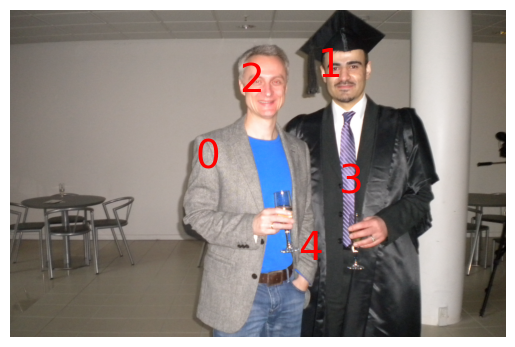

In [9]:

if len(faces) > 1: 
    print("Multiple faces detected! Please help determine what face to focus on by changing the 'face_index' variable ")
    fig, ax = plt.subplots()
    ax.imshow(image)
    text_kwargs = dict(ha='left', va='top', fontsize=28, color='r')
    for i, (x, y, w, h) in enumerate(faces):
        # rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        plt.text(x,y, i, **text_kwargs)
    # ax.add_patch(rect)
    plt.axis('off')
    plt.show()


    face_index = 1 # change here if multiple faces are detected
elif len(faces) == 1: 
    face_index = 0
else: 
    print("No faces detected, skipping final cropping ")


(-0.5, 786.5, 787.5, -0.5)

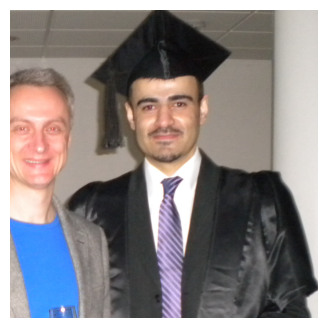

In [45]:
x, y, w, h = faces[face_index]

if w > h:
    measure = w
else: 
    measure = h 


x_min = x-measure*1.25 if x-measure*1.25 > 0 else 0
x_max = x_min+3.5*measure if x_min+3.5*measure < image.width else image.width
y_min = y-measure if y-measure > 0 else 0
y_max = y_min+3.5*measure if y_min+3.5*measure < image.height else image.height

cropped_image = image.crop((x_min, y_min, x_max, y_max))

plt.figure(figsize=(8,4))
plt.imshow(cropped_image)
plt.axis('off')

# Removing background 

For removing background we suggest using using the website [remove.bg](https://www.remove.bg/), which provides the best found results. 

Simply export the cropped image and specify the path to the modified image afterwards. 

In [46]:
# Exporting cropped image
cropped_image.save(f'Pictures/cropped/cropped_image_{name}.png')

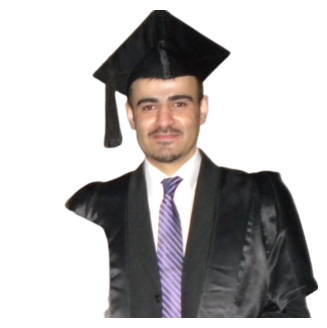

In [47]:
# Importing image 
background_removed = Image.open(f"/home/vap/Downloads/cropped_image_{name}-removebg-preview.png")
plt.figure(figsize=(8,4))
plt.imshow(background_removed)
plt.axis('off')

final_image = background_removed

# Inpainting
Inpainting is entirely voluntary, but is suggested if parts of the person is missing. Furthermore, you may choose to use inpainting to remove distracting objects from the photo or to edit outfits or stances (with varying quality)

First, all necessary components are installed to perform inpaitning using library ["latent diffusion"](https://github.com/CompVis/latent-diffusion)

First, a user interface lets to mark the area, where you want to perform inpainting

Second, inpainting is performed from the latent_diffussion library itself. The step needed for performing inpainting are described below. This is done in a different enviroment due to dependency issues

(-0.5, 498.5, 499.5, -0.5)

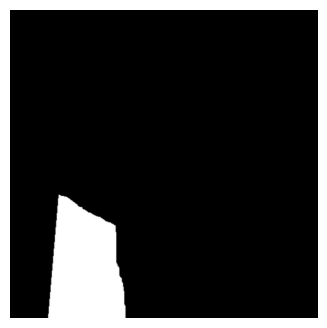

In [48]:
import importlib
import tools.mask_ui as mask_ui
importlib.reload(mask_ui) # ensures that change in tools/mask_ui.py are loaded

from tools.mask_ui import MaskUI

root = tk.Tk()
app = MaskUI(root)
app.load_image(background_removed.copy())
root.mainloop()

mask = app.mask

plt.figure(figsize=(8,4))
plt.imshow(mask)
plt.axis('off')

In [49]:
# Take ratio aspect into consideration
input_img = resize_wrt_ratio(background_removed, 512)
input_mask = resize_wrt_ratio(mask, 512)

# editing input_img to not be transparent, as latentdiffusion does not work well with transparent images 
bg = Image.new(mode = "RGB", size = (512,512),
               color = (200, 200, 200)) # If you change background on poster, remember to also change this
bg.paste(input_img, (266-int(input_img.width/2),0), mask=input_img)
input_img = bg

bg = Image.new(mode = "RGB", size = (512,512),
               color = (0, 0, 0)) # If you change background on poster, remember to also change this
bg.paste(input_mask, (266-int(input_mask.width/2),0))
input_mask =  bg


In [18]:
! git clone https://github.com/CompVis/latent-diffusion latentdiffusion
! rm latentdiffusion/data/inpainting_examples/*

Cloning into 'latentdiffusion'...
remote: Enumerating objects: 341, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 341 (delta 116), reused 107 (delta 107), pack-reused 169
Receiving objects: 100% (341/341), 28.69 MiB | 6.87 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [61]:

input_img.save(f'latentdiffusion/data/inpainting_examples/{name}.png')
input_mask.save(f'latentdiffusion/data/inpainting_examples/{name}_mask.png')

## Performing inpainting with latent_diffusion 

We follow the steps from their [github](https://github.com/CompVis/latent-diffusion), and add a few more to combat some dependency issues. Run the below commands in your terminal from the root PhD_Image folder or cd right into latentdiffusion

If you want to rerun inpainting (eg. if you're unhappy with the results), simple run the last command

In [27]:
#### RUN IN TERMINAL

cd latentdiffusion

# Init environment 
conda env create -f environment.yaml
conda activate ldm
pip install transformers==4.19.2 scann kornia==0.6.4 torchmetrics==0.5.0 # we use 0.5.0 instead of 0.6.0
pip install git+https://github.com/arogozhnikov/einops.git
# pip install omegae

# to fix local dep issues
pip install pytorch-lightning==1.6.5
pip install chardet

# we then download the models 
mkdir -p models/rdm/rdm768x768/
wget -O models/rdm/rdm768x768/model.ckpt https://ommer-lab.com/files/rdm/model.ckpt
wget -O models/ldm/inpainting_big/last.ckpt https://heibox.uni-heidelberg.de/f/4d9ac7ea40c64582b7c9/?dl=1

# running inpainting

sed -i -e 's/from torch._six/# from torch._six/g' src/taming-transformers/taming/data/utils.py # to remove deprecated function thats not being used anyway 
python scripts/inpaint.py --indir data/inpainting_examples/ --outdir outputs/inpainting_results

SyntaxError: invalid decimal literal (1054697258.py, line 17)

In [1]:
results = Image.open(f'latentdiffusion/outputs/inpainting_results/{name}.png')
final_image = results

plt.figure(figsize=(8,4))
plt.imshow(results)
plt.axis('off')

NameError: name 'Image' is not defined

# Creating poster
We are finally ready to create the poster, which will go up on the Wall of Fame. Once done, print out the a4 pdf and you will have your picture ready for framing

In [64]:
# resizing image to fit unto poster
graduation_photo = final_image.copy()
desired_height = 1100 # we want pictures to be same height, varying widths 


graduation_photo = resize_wrt_ratio(graduation_photo, desired_height)



In [71]:
from PIL import Image, ImageOps, ImageDraw, ImageFont
from textwrap import wrap

edge = Image.new(mode = "RGB", size = (1870, 2620), 
                        color = (200,200,200) ) 

poster = Image.new(mode = "RGB", size = (1860, 2610), # size as the used frames (A5 size 1748,2480)
                        #    color = (102, 102, 102)) # grey
                        # color = (84, 97, 110)) # dusty aalborg blue
                        color = (255,255,255) ) # white

edge.paste(poster,((5,5))) # adding edge to the poster is easier to cut from white paper 
poster = edge

font_color = (33,26,82)
font_size = 80
# Add text to image
draw = ImageDraw.Draw(poster)
draw.fill = 'white'
draw.font = ImageFont.truetype('Poster/Requirements/Barlow-Medium.ttf', size=80)

# add classic aau background waves
aau_waves = Image.open('Poster/Requirements/AAU_BOELGER_RGB-03.png')
aau_waves = aau_waves.resize((1860, 2610))
aau_waves = aau_waves.convert('LA').convert('RGBA') # converting to grayscale wrt transparency 
aau_waves2 = aau_waves.copy()
aau_waves2.putalpha(20)
aau_waves.paste(aau_waves2, aau_waves)
poster.paste(aau_waves, (0,0), mask=aau_waves)


# PHD NAME
# textpos_width, textpos_height = (poster.width/2, textpos_height+(i+1.5)*90)
textpos_width, textpos_height = (poster.width/2, 250)
name_font = ImageFont.truetype('Poster/Requirements/Barlow-Medium.ttf', size=font_size)
msg = your_name 
draw.text(((textpos_width),textpos_height), msg.upper(), anchor="ms", font=name_font,fill=font_color)


# add modified picture of person and frame
image_height_placement = 400
frame_width = 0
edge_width = 6 # even number please

# frame border
frame = Image.new(mode = "RGB", 
                   size = (graduation_photo.height+frame_width+edge_width, graduation_photo.height+frame_width+edge_width),  
                #    color = (150, 150, 150))
                color=font_color)
poster.paste(frame, ((poster.width//2) - (frame.width//2), image_height_placement-int(frame_width/2+edge_width/2)))
# frame
frame = Image.new(mode = "RGB", 
                   size = (graduation_photo.height+frame_width, graduation_photo.height+frame_width),  
                   color = (200, 200, 200))
poster.paste(frame, ((poster.width//2) - (frame.width//2), image_height_placement-(int(frame_width/2))))
#image
try: 
    poster.paste(graduation_photo, ((poster.width//2) - (graduation_photo.width//2), image_height_placement), mask=graduation_photo)
except: 
    poster.paste(graduation_photo, ((poster.width//2) - (graduation_photo.width//2), image_height_placement))

# TITLE
# textpos_width, textpos_height = (poster.width/2, 1550)
textpos_width, textpos_height = (poster.width/2, 1700)
title_font = ImageFont.truetype('Poster/Requirements/Barlow-Medium.ttf', size=font_size)
for i, line in enumerate(wrap(phd_title, 30)): # second arg in wrap: max number of chars per line
    draw.text(((textpos_width),textpos_height + i*(font_size+10)), line.upper(), anchor="ms", font=title_font,fill=font_color)


# PHD DEFENCE DATE
textpos_width, textpos_height = (poster.width/2, textpos_height+(i+1.5)*(font_size+10))
# textpos_width, textpos_height = (poster.width/2, textpos_height+100)
date_font = ImageFont.truetype('Poster/Requirements/Barlow-Medium.ttf', size=font_size-20)
msg = "Ph.D Defense " + date_of_graduation
draw.text(((textpos_width),textpos_height), msg, anchor="ms", font=date_font,fill=font_color)


#  AAU + VAPLAB Logo
aau_logo = Image.open('Poster/Requirements/__AAU_CENTER_RGB.png')
aau_logo.thumbnail((200,200))
poster.paste(aau_logo, (poster.width//2 - aau_logo.width//2, poster.height - aau_logo.height - 100), mask=aau_logo)

# textpos_width, textpos_height = (poster.width/2, 50)
# vap_font = ImageFont.truetype('Poster/Barlow-Black.ttf', size=23)
# draw.text(((textpos_width),textpos_height), "V i s u a l   A n a l y s i s   a n d ".upper(), anchor="ms", font=vap_font)
# draw.text(((textpos_width),textpos_height+30), "P e r c e p t i o n   L a b".upper(), anchor="ms", font=vap_font)

# display(poster)
poster.save(f"Poster/Outputs/poster_{name}.png")
poster.save(f"Poster/Outputs/poster_{name}_a5.pdf")

a4_doc = Image.new(mode = "RGB", size = (2480, 3508), # A4 size
                           color = (255, 255, 255))

a4_doc.paste(poster, (200,200))
a4_doc.save(f"Poster/Outputs/poster_{name}_a4.pdf")

And now you're done, congrats! 

You can print the poster_{name}_a4 pdf, and you get a picture that fits the frames perfectly :)

# For future developers of this script: 
Hi and welcome to this task! To help you determine what areas needs improvements, I have written out solutions that have already been looked into or tested,  but did not make the cut

### For removing background: 
- Python library *rembg* was used, but did not remove background as well as remove.bg (but unlike remove.bg, it does not degrade the image). Furthermore, the dependencies for *rembg* clashes massively with the rest of the dependencies

### For inpainting
- *Generative_inpainting_pytorch* did not produce good results

The current solution, *latent_diffusion* does not produce super good results either, but it was the best solution found, that does not exist behind a paywall 

### For fixing postures 
- *Coordinate_based_inpainting* was investigated, but requires a UV map of each person (thus scratched)
- *DragGAN* was looked into, but due to dependency clashes between NVIDIA and ninja build, it was not used. 

### For creating poster
- Python library *docx* was previously used for creating a word document instead of an image, but it was not possible to add a background image, and thus this solution was scratched
- *Niceposter* was considered, but it was deemed that there wasn't enough options to create the poster we wanted 